I0000 00:00:1750877558.185166      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/30


I0000 00:00:1750877617.283906      93 service.cc:148] XLA service 0x7bd9f8013870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750877617.284470      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750877619.868457      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/341 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.3507 - loss: 1.2973   

I0000 00:00:1750877628.902643      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


341/341 ━━━━━━━━━━━━━━━━━━━━ 155s 275ms/step - accuracy: 0.7523 - loss: 0.8674 - val_accuracy: 0.9884 - val_loss: 0.1385
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 103s 212ms/step - accuracy: 0.8556 - loss: 0.6583 - val_accuracy: 0.9312 - val_loss: 0.2591
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 103s 211ms/step - accuracy: 0.8858 - loss: 0.5774 - val_accuracy: 0.9871 - val_loss: 0.1697
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 103s 213ms/step - accuracy: 0.9024 - loss: 0.5563 - val_accuracy: 0.9981 - val_loss: 0.0775
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 102s 210ms/step - accuracy: 0.9121 - loss: 0.5174 - val_accuracy: 0.9968 - val_loss: 0.0685
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 103s 212ms/step - accuracy: 0.9261 - loss: 0.4887 - val_accuracy: 0.9942 - val_loss: 0.0590
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 101s 208ms/step - accuracy: 0.9351 - loss: 0.4657 - val_accuracy: 0.9968 - val_loss: 0.0458
Epoch 8/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 98s 202ms/step - accuracy: 0.9404 - loss: 0.458

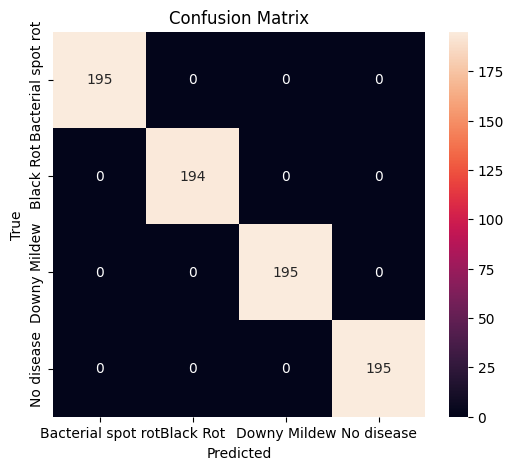

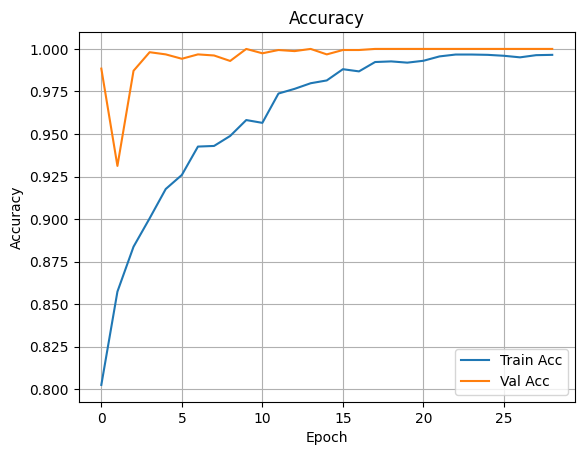

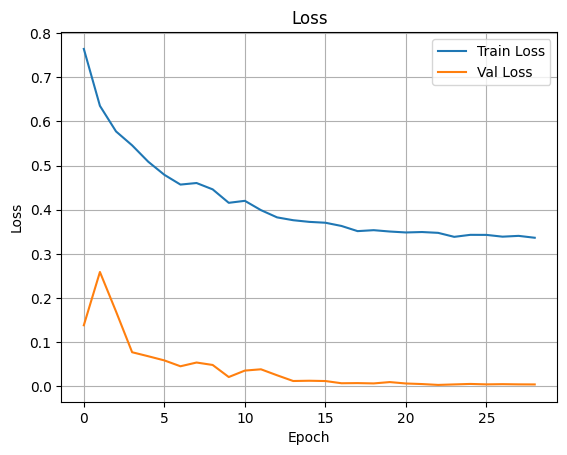

✅ Model saved as final_model_cutmix_resnet50v2_se.h5


In [2]:
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter

# 1️⃣ Setup
tf.keras.mixed_precision.set_global_policy("mixed_float16")
SEED = 42; IMG_SIZE = 256; BATCH = 16; EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# 2️⃣ Dataset Paths
ORIG = "/kaggle/input/vegnet-an-extensive-dataset-of-cauliflower-images/dataset/Original Dataset"
AUG = "/kaggle/input/vegnet-an-extensive-dataset-of-cauliflower-images/dataset/Augmented Dataset"
CLASSES = sorted(os.listdir(ORIG))
cls2idx = {cls: idx for idx, cls in enumerate(CLASSES)}

# 3️⃣ Load, Balance & Split Data
def load_data():
    paths, labels = [], []
    for folder in [ORIG, AUG]:
        for cls in CLASSES:
            d = os.path.join(folder, cls)
            if os.path.isdir(d):
                for f in os.listdir(d):
                    if f.lower().endswith(('jpg', 'jpeg', 'png')):
                        paths.append(os.path.join(d, f))
                        labels.append(cls2idx[cls])
    paths, labels = np.array(paths), np.array(labels)

    # Oversample to balance classes
    counter = Counter(labels)
    max_count = max(counter.values())
    X_aug, y_aug = [], []
    for cls in counter:
        idxs = np.where(labels == cls)[0]
        reps = max_count // len(idxs)
        rem = max_count % len(idxs)
        sampled = np.concatenate([np.tile(idxs, reps), np.random.choice(idxs, rem)])
        X_aug += paths[sampled].tolist()
        y_aug += labels[sampled].tolist()

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        np.array(X_aug), np.array(y_aug), test_size=0.10, stratify=y_aug, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.222, stratify=y_trainval, random_state=SEED)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# 4️⃣ Data Augmentation & CutMix
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, tf.one_hot(label, len(CLASSES))

def cutmix(ds, alpha=1.0):
    def _cutmix(imgs, labs):
        lam = np.random.beta(alpha, alpha)
        idx = tf.random.shuffle(tf.range(tf.shape(imgs)[0]))
        imgs2, labs2 = tf.gather(imgs, idx), tf.gather(labs, idx)
        rx, ry = tf.random.uniform([], 0, IMG_SIZE, dtype=tf.int32), tf.random.uniform([], 0, IMG_SIZE, dtype=tf.int32)
        rw = tf.cast(IMG_SIZE * tf.math.sqrt(1. - lam), tf.int32)
        x1, y1 = tf.clip_by_value(rx - rw//2, 0, IMG_SIZE), tf.clip_by_value(ry - rw//2, 0, IMG_SIZE)
        x2, y2 = tf.clip_by_value(rx + rw//2, 0, IMG_SIZE), tf.clip_by_value(ry + rw//2, 0, IMG_SIZE)
        crop = imgs2[:, y1:y2, x1:x2, :]
        paddings = [[0, 0], [y1, IMG_SIZE - y2], [x1, IMG_SIZE - x2], [0, 0]]
        patch = tf.pad(crop, paddings)
        mixed = imgs * (1 - tf.cast(patch != 0, imgs.dtype)) + patch
        return mixed, lam * labs + (1 - lam) * labs2
    return ds.map(lambda x, y: _cutmix(x, y), num_parallel_calls=AUTOTUNE)

def make_ds(paths, labels, train=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    if train:
        ds = ds.shuffle(2048, seed=SEED).batch(BATCH).prefetch(AUTOTUNE)
        ds = cutmix(ds)
    else:
        ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

# 5️⃣ Model: ResNet50V2 + SE Attention
def build_model():
    base = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for l in base.layers[:-20]:
        l.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    se = layers.Dense(x.shape[-1]//8, activation='relu')(x)
    se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
    x = layers.Multiply()([x, se])
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(len(CLASSES), activation='softmax', dtype='float32')(x)
    return keras.Model(base.input, out)

# 6️⃣ Train + Evaluate
def train_and_evaluate():
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_data()
    train_ds = make_ds(X_train, y_train, train=True)
    val_ds = make_ds(X_val, y_val)
    test_ds = make_ds(X_test, y_test)

    model = build_model()
    lr = keras.optimizers.schedules.CosineDecay(1e-3, decay_steps=EPOCHS * len(train_ds))
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[
        keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ])

    # Evaluation
    model.load_weights("best_model.h5")
    y_true, y_pred = [], []
    for x, y in make_ds(X_test, y_test):
        p = model.predict(x, verbose=0)
        y_true.extend(np.argmax(y.numpy(), axis=1))
        y_pred.extend(np.argmax(p, axis=1))

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plots
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.show()

    model.save("final_model_cutmix_resnet50v2_se.h5")
    print("✅ Model saved as final_model_cutmix_resnet50v2_se.h5")

# 7️⃣ Run
if __name__ == "__main__":
    train_and_evaluate()